In [1]:
import plumed
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1977) # makes notebook reproducible

In [2]:
kBT=1.2388545199729883*2

In [3]:
# This is the main run
colvar_rew=plumed.read_as_pandas("COLVAR_REWEIGHT")

In [4]:
# Return average and error with bootstrap
# nblocks: number of blocks
# discard: discarded fraction
def analyze(traj,nblocks,discard=0):
    l=int(len(traj)*(1.0-discard))
    # make sure the number of frames is a multiple of nblocks (discard the first few frames)
    l=(l//nblocks)*nblocks
    b=np.array(traj["metad.bias"])
    b-=np.max(b) # avoid overflows
    w=np.exp(b/kBT)[-l:].reshape((nblocks,-1)) # weights
    isA=np.int_(traj["lambda"]==0)[-l:].reshape((nblocks,-1)) # 1 if in A
    isB=np.int_(traj["lambda"]==np.max(traj["lambda"]))[-l:].reshape((nblocks,-1)) # 1 if in B
    B=200 # number of bootstrap iterations
    boot=np.random.choice(nblocks,size=(B,nblocks))
    popA=np.average(isA[boot],axis=(1,2),weights=w[boot])
    popB=np.average(isB[boot],axis=(1,2),weights=w[boot])
    df=np.log(popA/popB) # this is in kBT units
    popA0=np.average(isA,weights=w)
    popB0=np.average(isB,weights=w)
    return np.log(popA0/popB0),np.std(df)

# time-averaged potential, computed averaging over the final 25%
def time_average(hills,t0=0.75):
    n0=int(len(hills)*t0)
    w=np.hstack((np.ones(n0),np.linspace(1.0,0.0,len(hills)-n0)))
    hills=hills.copy()
    hills.height*=w
    return hills

# bias potential computed from hills
# can be used to recompute V(lambda) given the hills file
# can be used on a hills file produced by time_average()
# the result is an array with V for each lambda index
def metad_bias(hills):
    bias=[]
    for i in range(np.max(hills["lambda"]+1)):
        bias.append(np.sum(np.array(hills["lambda"]==i,dtype=int)*hills["height"]/hills["biasf"]*(hills["biasf"]-1)))
    return np.array(bias)

In [5]:
# block analysis
dd=[]
nblocks=[100000,50000,20000,10000,5000,2000,1000,500,200,100,50,20,10,5]
for nb in nblocks:
    dd.append(analyze(colvar_rew,nb,discard=0.0))
dd=np.array(dd)
dd

array([[-3.20500138,  0.00869569],
       [-3.20067554,  0.01011054],
       [-3.20320949,  0.01512304],
       [-3.20067554,  0.02194774],
       [-3.20067554,  0.02983902],
       [-3.20067554,  0.04145926],
       [-3.20067554,  0.05008426],
       [-3.20067554,  0.05960733],
       [-3.20067554,  0.06582666],
       [-3.20067554,  0.06156457],
       [-3.20067554,  0.05197067],
       [-3.20067554,  0.03829368],
       [-3.20067554,  0.0172728 ],
       [-3.20067554,  0.00455241]])

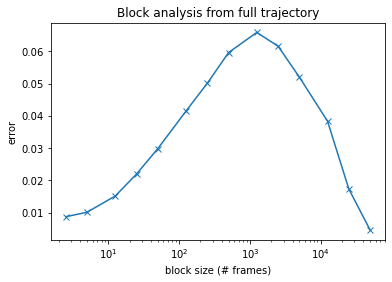

In [6]:
plt.plot(len(colvar_rew)/np.array(nblocks),dd[:,1],"x-")
plt.xscale("log")
plt.title("Block analysis from full trajectory")
plt.xlabel("block size (# frames)")
plt.ylabel("error")
plt.show()

In [7]:
# analyze second half of trajectory
dd=[]
for nb in nblocks:
    dd.append(analyze(colvar_rew,nb,discard=0.5))
dd=np.array(dd)
dd

array([[-3.20058023,  0.01122499],
       [-3.20058023,  0.01241264],
       [-3.20292065,  0.01746575],
       [-3.20292065,  0.02093254],
       [-3.19502413,  0.03145692],
       [-3.20318613,  0.05172173],
       [-3.19502413,  0.06328087],
       [-3.19502413,  0.07989048],
       [-3.19502413,  0.08947536],
       [-3.19502413,  0.0866361 ],
       [-3.19502413,  0.10238465],
       [-3.19502413,  0.07469347],
       [-3.19502413,  0.07463245],
       [-3.19502413,  0.02846076]])

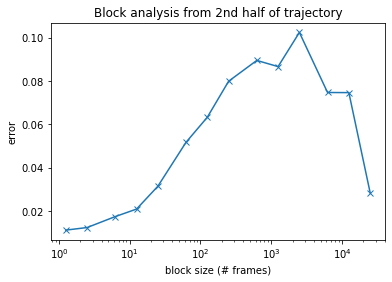

In [8]:
plt.plot(0.5*len(colvar_rew)/np.array(nblocks),dd[:,1],"x-")
plt.xscale("log")
plt.title("Block analysis from 2nd half of trajectory")
plt.xlabel("block size (# frames)")
plt.ylabel("error")
plt.show()

Best block size seems 2500 frames (~ 100 blocks for the full traj) ~ 50 ps.
Order of magnitude of the error seems consistent with what was reported. In the analysis below we fix this as the block size.

We then read the full dataset: 20 simulations where the potential is kept constant in the last 1 ns. Notice that I will either analyze the last fifth or the fourth fifth of the trajectory. Namely:

- t=4 to 5 ns: potential is static
- t=3 to 4 ns: potential is changing

Obviously, the latter is reprentative of a simulation where UPDATE_UNTIL was not used

In [9]:
colvar_all=[]
for i in range(1,21):
    colvar_all.append(plumed.read_as_pandas("../data/UPDATE_UNTIL/rep_{}/COLVAR_REWEIGHT".format(i)))
    colvar_all[-1].time*=0.02 # fix time to ps
hills_all=[]
for i in range(1,21):
    hills_all.append(plumed.read_as_pandas("../data/UPDATE_UNTIL/rep_{}/HILLS_LAMBDA".format(i)))

I now analyze all the trajectories. I am using three different approaches:
- use only the static potential fraction (last 1 ns)
- use the 3 to 4 ns fraction, assuming bias has always been the final one (this is the standard reweighting discussed in the tutorial)
- use the 3 to 4 ns fraction, assuming bias has always been the time average of the bias on that interval (this is compulsory when using non-well-tempered metadynamics, and should be recommended with well-tempered metadynamics as well if biasfactor is high)

Notice that the usual trick to obtain the time-averaged potential is to scale hills hight with a factor going lineary to zero from, say t=3 to t=4 ns. This is analytically equivalent to averaging the potential. See the time_average() function above

In [10]:
dd=[]
for i in range(len(colvar_all)):
    df=colvar_all[i]
    # analyze the static potential part
    df1=df.loc[(df['time'] >= 4000)]
    # analyze 3000-4000 ps assuming the final potential
    df2=df.loc[(df['time'] <= 4000) & (df['time'] > 3000) ]
    # analyze 3000-4000 ps assuming the time-averaged potential
    df3=df.loc[(df['time'] <= 4000) & (df['time'] > 3000) ].copy()
    df3["metad.bias"]=metad_bias(time_average(hills_all[i]))[np.int_(df3["lambda"])]   
    dd.append((
        analyze(df1,len(df1)//2500),
        analyze(df2,len(df2)//2500),
        analyze(df3,len(df3)//2500))
    )
dd=np.array(dd)
# dd[i,j,k]
# i=0..19 (iteration)
# j=0..2 (method)
# k=0..1 (average and stddev)

In [11]:
# reasonable range to show Gaussians
x=np.linspace(np.min(dd[:,:,0])-2*np.max(dd[:,:,1]),np.max(dd[:,:,0])+2*np.max(dd[:,:,1]),500)

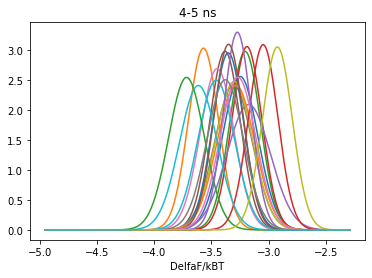

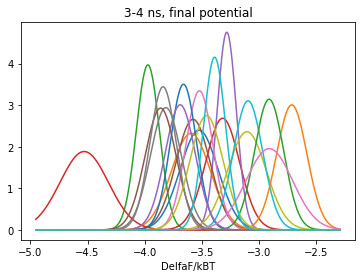

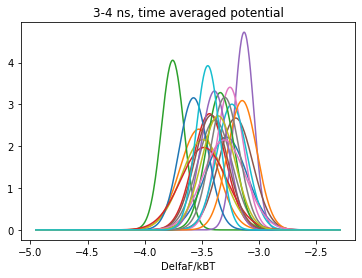

In [34]:
for i in range(len(dd)):
    plt.plot(x,1/np.sqrt(2.0*np.pi*dd[i,0,1]**2)*np.exp(-0.5*(x-dd[i,0,0])**2/dd[i,0,1]**2))
plt.title("4-5 ns")
plt.xlabel("DelfaF/kBT")
plt.show()
for i in range(len(dd)):
    plt.plot(x,1/np.sqrt(2.0*np.pi*dd[i,1,1]**2)*np.exp(-0.5*(x-dd[i,1,0])**2/dd[i,1,1]**2))
plt.title("3-4 ns, final potential")
plt.xlabel("DelfaF/kBT")
plt.show()
for i in range(len(dd)):
    plt.plot(x,1/np.sqrt(2.0*np.pi*dd[i,2,1]**2)*np.exp(-0.5*(x-dd[i,2,0])**2/dd[i,2,1]**2))
plt.title("3-4 ns, time averaged potential")
plt.xlabel("DelfaF/kBT")
plt.show()

In [35]:
# in principle, the optimal way to combine all these simulations is to use WHAM
# since they are performed with a different potential
# for simplicity I just take their average here
# I consider this as a reference result, hopefully it is
# consistent with longer reference simulations
reference=np.average(dd[:,0,0])

print("Reference value:",reference)
# Z score:
Z=(dd[:,:,0]-reference)/dd[:,:,1]
print("For each method, rmse of simulations wrt reference and <Z**2> (should be ~ 1)")
print("4-5 ns, with static potential:",np.sqrt(np.sum((dd[:,0,0]-reference)**2)),np.sqrt(np.average(Z[:,0]**2)))
print("3-4 ns, with final potential:",np.sqrt(np.sum((dd[:,1,0]-reference)**2)),np.sqrt(np.average(Z[:,1]**2)))
print("3-4 ns, with averaged potential:",np.sqrt(np.sum((dd[:,2,0]-reference)**2)),np.sqrt(np.average(Z[:,2]**2)))

Reference value: -3.3248651316892315
For each method, rmse of simulations wrt reference and <Z**2> (should be ~ 1)
4-5 ns, with static potential: 0.8039510713356416 1.2591485212094868
3-4 ns, with final potential: 1.9903822884842213 3.081703821287536
3-4 ns, with averaged potential: 0.6954058612188041 1.3716414371628558


First and third method gives comparable results.
Second method gives less accurate result (RMSE~2) but a similar error estimate. Error is thus underestimated.